In [76]:
from numpy import pi, log, sqrt 
import getdist
import numpy as np
from io import StringIO
from getdist import plots, MCSamples
import random
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.integrate import odeint
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from scipy import stats
import pypolychord
from pypolychord.settings import PolyChordSettings
from pypolychord.priors import UniformPrior, GaussianPrior
import scipy.optimize as op
from numpy.linalg import inv
from mpi4py import MPI
import sympy as sp
import scipy.linalg as la
import pandas as pd

# Cosmic Chronometers Dataset with Full Covariance

**Source:** [https://gitlab.com/mmoresco/CCcovariance](https://gitlab.com/mmoresco/CCcovariance)

### Description

This analysis utilizes the Cosmic Chronometers (CC) dataset with the full covariance matrix and prepares the likelihood function for cosmological parameter estimation.

### Citation Guidelines

If you use this dataset, please cite the following foundational works by Prof. Dr. Moresco:

- Moresco et al. (2016), [arXiv:1804.05864](https://doi.org/10.48550/arXiv.1804.05864)  
- Moresco (2020), [arXiv:2003.07362](https://doi.org/10.48550/arXiv.2003.07362)  

Additionally, when using the same data, please acknowledge these important references:

- Simon et al. (2005), [arXiv:1201.3609](https://doi.org/10.48550/arXiv.1201.3609)  
- Stern et al. (2010), [arXiv:1503.01116](https://doi.org/10.48550/arXiv.1503.01116)  
- Moresco et al. (2012), [arXiv:1601.01701](https://doi.org/10.48550/arXiv.1601.01701)  

In [77]:
#Load CC dataset and Build Full Covariance Matrix
filename = 'data/HzTable_MM_BC03.dat'
z, Hz, errHz = np.genfromtxt(filename, comments='#', usecols=(0,1,2), unpack=True, delimiter=',')
ref = np.genfromtxt(filename, comments='#', usecols=(3), unpack=True, dtype=str, delimiter=',')


filename = 'data/data_MM20.dat'
zmod, imf, slib, sps, spsooo = np.genfromtxt(filename, comments='#', usecols=(0,1,2,3,4), unpack=True)

cov_mat_diag = np.zeros((len(z), len(z)), dtype='float64')

for i in range(len(z)):
	cov_mat_diag[i,i] = errHz[i]**2

imf_intp = np.interp(z, zmod, imf)/100
slib_intp = np.interp(z, zmod, slib)/100
sps_intp = np.interp(z, zmod, sps)/100
spsooo_intp = np.interp(z, zmod, spsooo)/100

cov_mat_imf = np.zeros((len(z), len(z)), dtype='float64')
cov_mat_slib = np.zeros((len(z), len(z)), dtype='float64')
cov_mat_sps = np.zeros((len(z), len(z)), dtype='float64')
cov_mat_spsooo = np.zeros((len(z), len(z)), dtype='float64')

for i in range(len(z)):
	for j in range(len(z)):
		cov_mat_imf[i,j] = Hz[i] * imf_intp[i] * Hz[j] * imf_intp[j]
		cov_mat_slib[i,j] = Hz[i] * slib_intp[i] * Hz[j] * slib_intp[j]
		cov_mat_sps[i,j] = Hz[i] * sps_intp[i] * Hz[j] * sps_intp[j]
		cov_mat_spsooo[i,j] = Hz[i] * spsooo_intp[i] * Hz[j] * spsooo_intp[j]


cov_mat = cov_mat_spsooo+cov_mat_imf+cov_mat_diag
inv_cov_mat = inv(cov_mat)

cov_mat_cc = inv_cov_mat

# PantheonPlus Dataset (CosmoSIS Likelihood)

**Source Link:** [Pantheon+ CosmoSIS Likelihood Script](https://github.com/PantheonPlusSH0ES/DataRelease/blob/main/Pantheon%2B_Data/5_COSMOLOGY/cosmosis_likelihoods/Pantheon%2B_only_cosmosis_likelihood.py)  
**Dataset Link:** [Pantheon+ Distances and Covariance](https://github.com/PantheonPlusSH0ES/DataRelease/tree/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR)

### Description

This analysis utilizes the full **STAT+SYS** covariance matrix provided in the PantheonPlus data release to construct a supernova likelihood. The approach follows the CosmoSIS likelihood format and incorporates both statistical and systematic uncertainties in the SN Ia light curves.

### Citation Guidelines

If you use this dataset or the associated likelihood script in your research, please cite the following key works:

- **Pantheon+ Compilation and Analysis Methodology:**
  - Brout et al. (2022), [arXiv:2112.03863](https://doi.org/10.48550/arXiv.2112.03863)
  - Scolnic et al. (2022), [arXiv:2202.04077](https://doi.org/10.48550/arXiv.2202.04077)

- **Covariance Matrix Construction:**
  - Conley et al. (2011), [arXiv:1104.1443](https://doi.org/10.48550/arXiv.1104.1443)

In [78]:
#Load Pantheonplus dataset and Build the Covariance Matrix
values_filename = 'data/Pantheon+SH0ES.dat'
cov_filename = 'data/Pantheon+SH0ES_STAT+SYS.cov'

data = pd.read_csv(values_filename, sep=r'\s+')
origlen = len(data)
ww = (data['zHD'] > 0.01)  # Filter condition for zHD > 0.01
zcmb = data['zHD'][ww].values  # vpec corrected redshift (zCMB)
zhelio = data['zHEL'][ww].values  # Heliocentric redshift
mag = data['m_b_corr'][ww].values  # Corrected magnitudes
N = len(mag)

filename = cov_filename
#print("Loading covariance from {}".format(filename))
f = open(filename)
line = f.readline()
n = int(len(zcmb))
C = np.zeros((n,n))
ii = -1
jj = -1
mine = 999
maxe = -999
for i in range(origlen):
    jj = -1
    if ww[i]:
        ii += 1
    for j in range(origlen):
        if ww[j]:
            jj += 1
        val = float(f.readline())
        if ww[i]:
            if ww[j]:
                C[ii,jj] = val

f.close()
#print('Done')
cov = C
xdiag = 1/cov.diagonal()  # diagonal before marginalising constant
cov += 3**2
zmin = zcmb.min()
zmax = zcmb.max()
zmaxi = 1.1 ## we interpolate to 1.1 beyond that exact calc
#print("Pantheon SN: zmin=%f zmax=%f N=%i" % (zmin, zmax, N))
ninterp=150
zinter = np.linspace(1e-3, zmaxi, ninterp)
icov = la.inv(cov)

# DESI DR2 Dataset with Full Covariance

**Source of Dataset:**  
[DESI BAO Data - GitHub (CobayaSampler)](https://github.com/CobayaSampler/bao_data)

### Description

This analysis utilizes incorporates the **DESI Data Release 2 (DR2)** dataset, which includes baryon acoustic oscillation (BAO) measurements derived from over 14 million galaxies and quasars. The full covariance matrix is used in the likelihood analysis to properly account for measurement uncertainties and correlations between data points.

The dataset is made publicly available and formatted for direct use in cosmological inference frameworks such as [Cobaya](https://cobaya.readthedocs.io/) and [CosmoMC](https://cosmologist.info/cosmomc/).

### Citation Guidelines

If you use this dataset in your work, please cite the following:

- **DESI Collaboration (2024)**  
  _The completed DR2 BAO analysis methodology and results_  
  [arXiv:2503.14738](https://doi.org/10.48550/arXiv.2503.14738)

In [79]:
#loading BAO dataset with Covarinace matrix
dirBD= "data/desi_gaussian_bao_ALL_GCcomb_mean.txt"
BaoData = np.genfromtxt(dirBD)
xarr = np.array(BaoData[:,0])
yarr = np.array(BaoData[:,1])

funarr = np.genfromtxt(dirBD,dtype='str')[:,2]
print(funarr)

def modelArr(name):
    mod = []

    for j in range(len(funarr)):
        if (funarr[j] == name):
             mod.append([xarr[j],yarr[j]])
    mod = np.array(mod)
    mod = mod[np.argsort(mod[:,0])]
    return mod

cov_bao = np.loadtxt("data/desi_gaussian_bao_ALL_GCcomb_cov.txt")  
cov_bao_inv = np.linalg.inv(cov_bao)

['DVrd' 'DMrd' 'DHrd' 'DMrd' 'DHrd' 'DMrd' 'DHrd' 'DMrd' 'DHrd' 'DMrd'
 'DHrd' 'DHrd' 'DMrd']


1. **Define the normalized Hubble function** $E(\theta, z)$:

$$
E(z) = \sqrt{\Omega_m (1 + z)^3 + (1 - \Omega_m)}
$$

2. **The Hubble function** $H(\theta, z)$:

$$
H(z) = H_0 \times E(z)
$$


In [80]:
#H functions
c = 299792.458

def E(theta,z):
    H0, Om, rd = theta
    OL = 1 - Om
    return np.sqrt(Om*(1+z)**3 + OL)

def H(theta,z):
    H0, Om, rd = theta
    arr = []
    for j in range(len(z)):
        arr.append(H0*E(theta,z[j]))
    arr = np.array(arr)
    return arr

H([67,0.32,147],[1,2,3])

array([120.6      , 204.5421228, 308.2      ])

3. The comoving distance function $D_H(\theta, z)$:

$$
D_H(z) = \frac{c}{H(z)}
$$

4. The comoving distance scaled by the sound horizon:

$$
\frac{D_H(z)}{r_d} = \frac{c}{H(z) \times r_d}
$$


In [81]:
#DH functions
def DH(theta,z):
    H0, Om, rd = theta
    arr = []
    for j in range(len(z)):
        arr.append(c/(H0*E(theta,z[j])))
    arr = np.array(arr)
    return arr

def DHrd(theta,z):
    H0, Om, rd = theta
    arr = []

    for j in range(len(z)):
        arr.append(c/(H0*E(theta,z[j])*rd))
    arr = np.array(arr)
    return arr

DHrd([67,0.32,147],[1,2,3])

array([16.91048488,  9.97058429,  6.61714626])

The Sk function $S_k(\theta, x)$:

$$
S_k(x) = 
\begin{cases} 
\frac{\sin\left(\sqrt{-\Omega_k} \, x\right)}{\sqrt{-\Omega_k}} & \text{if } \Omega_k < -10^{-15} \\
\frac{\sinh\left(\sqrt{\Omega_k} \, x\right)}{\sqrt{\Omega_k}} & \text{if } \Omega_k > 10^{-15} \\
x & \text{if } \Omega_k = 0
\end{cases}
$$

Where:

* $\Omega_k$ is the curvature parameter (based on the `Ok` variable in your function).
* $x$ is the input variable in the function.

This function evaluates different cases based on the sign and magnitude of $\Omega_k$ (denoted as `Ok`), using either the sine or hyperbolic sine functions, or returning $x$ when $\Omega_k = 0$.


In [82]:
def Sk(theta,x):
    H0, Om, rd = theta
    Ok =0
    if Ok < -10**(-15):
        return np.sin(np.sqrt(-Ok)*x)/np.sqrt(-Ok)
    #if Ok == 0:
    #    return x
    elif Ok > 10**(-15):
        return np.sinh(np.sqrt(Ok)*x)/np.sqrt(Ok)
    else:
        return x

**Derivative of $\chi$ with respect to $z$** :

$$
\frac{d\chi}{dz} = \frac{1}{E(\theta, z)}
$$

**Integral of $\chi$** :

$$
\chi(z) = \int_0^z \frac{dz'}{E(\theta, z')}
$$


In [83]:
# function that returns dDC/dz,df/dz
def dchidz(x,z, H0, Om, rd):
    return 1/E([H0, Om, rd],z)

def chiInt(theta,z):
    H0, Om, rd = theta
    z = np.hstack((np.array((0)), z))
    arr = odeint(dchidz,0,z,args=(H0, Om, rd,))
    return np.delete(arr ,0)

chiInt([67,0.32,147],[1,2,3])

array([0.7624812 , 1.18936468, 1.45585048])

5. The comoving angular diameter distance is computed as: $D_M(\theta, z)$:

$$
D_M(z) = \frac{c}{H_0} \cdot S_k\left( \chi(z) \right)
$$

* $\chi(z) = \int_0^z \frac{c}{H(z')} \, dz'$ is the comoving radial distance
* $S_k(\chi)$ accounts for spatial curvature:

$$
S_k(\chi) =
\begin{cases}
\frac{1}{\sqrt{\Omega_k}} \sinh\left(\sqrt{\Omega_k} \chi\right) & \text{if } \Omega_k > 0 \ (\text{open}) \\
\chi & \text{if } \Omega_k = 0 \ (\text{flat}) \\
\frac{1}{\sqrt{|\Omega_k|}} \sin\left(\sqrt{|\Omega_k|} \chi\right) & \text{if } \Omega_k < 0 \ (\text{closed})
\end{cases}
$$

6. The comoving angular diameter distance scaled by the sound horizon:


$$
\frac{D_M(z)}{r_d} = \frac{c}{H_0 \cdot r_d} \cdot S_k\left( \chi(z) \right)
$$



In [84]:
#DM

def DM(theta,z):
    H0, Om, rd = theta
    chi = chiInt(theta,z)

    arr = []

    for i in range(len(z)):
        arr.append(c*Sk(theta,chi[i])/H0)
    arr = np.array(arr)
    arr.shape
    return arr

def DMrd(theta,z):
    H0, Om, rd = theta
    chi = chiInt(theta,z)

    arr = []

    for i in range(len(z)):
        arr.append(c*Sk(theta,chi[i])/(H0*rd))
    arr = np.array(arr)
    arr.shape
    return arr

DMrd([67,0.32,147],[1,2,3])

array([23.20906838, 36.20292027, 44.31444763])

7. The volume-averaged distance combines radial and transverse distances and is defined as:

$$
D_V(z) = \left[ z \cdot D_H(z) \cdot D_M(z)^2 \right]^{1/3}
$$

* $D_H(z) = \dfrac{c}{H(z)}$: the comoving Hubble distance
* $D_M(z)$: the comoving angular diameter distance
* This is often used when the BAO measurement is spherically averaged.

8. The volume-averaged diameter distance scaled by the sound horizon:

$$
\frac{D_V(z)}{r_d} = \frac{ \left[ z \cdot D_H(z) \cdot D_M(z)^2 \right]^{1/3} }{r_d}
$$

In [85]:
#DV

def DV(theta,z):
    H0, Om, rd = theta
    dh = DH(theta,z)
    dm = DM(theta,z)
    arr = []

    for i in range(len(z)):
        arr.append(np.cbrt(z[i]*dh[i]*dm[i]**2))
    arr = np.array(arr)
    arr.shape
    return arr

def DVrd(theta,z):

    H0, Om, rd = theta

    dh = DH(theta,z)
    dm = DM(theta,z)
    arr = []

    for i in range(len(z)):
        arr.append(np.cbrt(z[i]*dh[i]*dm[i]**2)/rd)
    arr = np.array(arr)
    arr.shape
    return arr

DVrd([67,0.32,147],[1,2,3])

array([20.88448766, 29.67649485, 33.90737919])

### Luminosity Distance

$$
D_L(z) = (1 + z) \cdot \frac{c \cdot \chi(z)}{H_0}
$$

### Distance Modulus

$$
\mu(z) = 5 \log_{10} \left( D_L(z) \right) + 25
$$

In [86]:
def DL(theta,z):
    H0, Om, rd = theta
    chi = chiInt(theta,z)
    return c*chi/H0

def mu(theta,z):
    H0, Om, rd = theta
    dL = DL(theta,z)
    mu = []

    for i in range(len(z)):
        mu.append(5*np.log10(dL[i]*(1+z[i])) + 25)
    mu = np.array(mu)
    mu.shape
    return mu

In [87]:
def Omega_Lambda(theta):
    H0, Om, rd = theta
    OL = 1 - Om
    return OL

### Log Likelihood Function for Cosmic Chronometer Measurements

Given a model prediction $H(z; \theta)$, observed data $H_z$, and the inverse covariance matrix $\mathbf{C}^{-1}$, the chi-squared statistic is computed as:

$$
\chi^2 = \left( H(z; \theta) - H_z \right)^T \cdot \mathbf{C}^{-1} \cdot \left( H(z; \theta) - H_z \right)
$$

The corresponding log-likelihood is:

$$
\ln \mathcal{L}(\theta) = -\frac{1}{2} \chi^2
$$


### Output Statistics

The function also returns:

* Minimum chi-squared: $\chi^2_{\text{min}}$
* Total number of data points: $N$
* Reduced chi-squared:

$$
\chi^2_{\text{red}} = \frac{\chi^2}{N - k}
$$

* $p$-value:

$$
p = 1 - F_{\chi^2}(\chi^2; \, \text{dof} = N - k)
$$

* Derived Cosmological Parameters:

$$
\Omega_\Lambda = 1 - \Omega_m \quad (\text{In the case Dark Energy Density })
$$


In [88]:
def lnlike(theta,model,z,Hz,cov_mat_cc):
    prediction = model(theta,z)
    residualcc = prediction - Hz
    chi2 = residualcc.T @ cov_mat_cc @ residualcc
    return chi2

def lnlikeCC(theta):
    chi = 0; i = 0
    chi += lnlike(theta, H, z, Hz, cov_mat_cc)
    i += len(z)
    OL = Omega_Lambda(theta)
    return -chi, [i, chi/(i-len(theta)),1-stats.chi2.cdf(x=chi, df=(i-len(theta))),OL]

print(lnlikeCC([67,0.32,147]))

(np.float64(-6.183367402883179), [15, np.float64(0.5152806169069316), np.float64(0.906557694340706), 0.6799999999999999])


### Log Likelihood Function for BAO Dataset with Full Covariance

Given model predictions $\hat{y}_i = f_i(z_i; \theta)$ (e.g., BAO observables like $D_H$, $D_V$, and $D_A$, etc.), observed data $y_i$, and the inverse covariance matrix $\mathbf{C}^{-1}$, the chi-squared statistic is computed as:

$$
\chi^2(\theta) = \left( \hat{y}(\theta) - y \right)^T \cdot \mathbf{C}^{-1} \cdot \left( \hat{y}(\theta) - y \right)
$$

The corresponding log-likelihood is:

$$
\ln \mathcal{L}(\theta) = -\frac{1}{2} \chi^2(\theta)
$$



In [89]:
# likelihood with covariance matrix
def lnlikecov(theta, model, x, y, cov):
    prediction = []

    for i in range(len(model)):
        fun = model[i]
        prediction.append(eval(fun)(theta, [x[i]]))
    prediction = np.array(prediction)[:, 0]
    vec = (prediction - y)
    result = np.dot(np.dot(vec, cov), vec.T)
    return result

print(lnlikecov([67, 0.32, 147], funarr, np.array(BaoData[:, 0]), np.array(BaoData[:, 1]), cov_bao_inv))

40.55527665589692


This function computes the log-likelihood of BAO data given cosmological parameters $\theta$. It calculates the chi-squared statistic comparing model predictions to observations using the inverse covariance matrix, then returns the negative chi-squared (log-likelihood), reduced chi-squared, p-value, and the derived parameter $\Omega_\Lambda$, providing a measure of fit quality and model consistency with the data.


In [90]:
def lnlikeBAO(theta):
    x = np.array(BaoData[:, 0])
    y = np.array(BaoData[:, 1])

    # Use your manually loaded inverse covariance matrix
    chi = lnlikecov(theta, funarr, x, y, cov_bao_inv)
    i = len(x)
    OL = Omega_Lambda(theta)
    return -chi, [chi, chi / (i - len(theta)), 1 - stats.chi2.cdf(x=chi, df=(i - len(theta))), OL]

lnlikeBAO([67,0.32,147])

(np.float64(-40.55527665589692),
 [np.float64(40.55527665589692),
  np.float64(4.0555276655896915),
  np.float64(1.3524100608619527e-05),
  0.6799999999999999])

### Log Likelihood Function for PantheonPlus Dataset with Full Covariance

In this analysis, I marginalize over the nuisance parameter $\mathcal{M}$ (the absolute magnitude offset) using the analytic approach described in Astier et al. (2001) [arXiv:astro-ph/0104009](https://arxiv.org/abs/astro-ph/0104009v1). The method uses the difference

$$
\Delta = 5 \log_{10} \left[d'_L(\theta, z_i)\right] - 5 \log_{10} \left[d'_L(\theta_{\text{true}}, z_i)\right]
\quad \text{(Equation A.8)}
$$

where $d'_L$ is the luminosity distance.

By construction, the minimized chi-squared at the true parameters satisfies

$$
\hat{\chi}^2_{\min} = \hat{\chi}^2(\theta_{\text{true}}) = 0.
$$

Assuming no prior knowledge of $M$, the likelihood is marginalized by integrating the general $\chi^2$ function over $M \in (-\infty, \infty)$:

$$
\tilde{\chi}^2 \equiv \chi^2_{M\text{-int}} = -2 \ln \left[\int_{-\infty}^{\infty} dM \exp\left(-\frac{1}{2} \chi^2 \right)\right]
\quad \text{(Equation A.9)}
$$

This integral can be evaluated analytically to give:

$$
\tilde{\chi}^2 = \hat{\chi}^2 - \frac{B^2}{C} + \ln \left(\frac{C}{2 \pi}\right)
\quad \text{(Equation A.10)}
$$

where

$$
B = \sum_{i=1}^n \frac{\Delta_i}{\sigma_i^2}
\quad \text{(Equation A.11)}
$$

and

$$
C = \sum_{i=1}^n \frac{1}{\sigma_i^2}
\quad \text{(Equation A.12)}
$$

Here, $\sigma_i^2$ are the variances from the covariance matrix.

### Reference

### Citation Guidelines

If you use this liklihood in your work, please cite the following:

- **Astier et al. (2001)** : _Supernovae and the Nature of the Dark Energy_ : [arXiv:astro-ph/0104009](https://arxiv.org/abs/astro-ph/0104009v1)


In [91]:
def A(theta, x, y, icov):
    Mu = mu(theta, x)
    residual = y - Mu 
    chit2 = residual.T @ icov @ residual
    B = np.sum(residual @ icov)
    C = np.sum(icov)
    chi2 = chit2 - (B**2 / C) + np.log(C / (2 * np.pi))
    return chi2

def lnlikeSNIa(theta):
    chi = A(theta, zcmb, mag, icov)
    i = len(zcmb)
    OL = Omega_Lambda(theta)
    return -chi, [chi, chi/(i-len(theta)),1-stats.chi2.cdf(x=chi, df=(i-len(theta))),OL]

print(lnlikeSNIa([67,0.32,147]))

(np.float64(-1400.0153971457628), [np.float64(1400.0153971457628), np.float64(0.8821773138914699), np.float64(0.9997167053005009), 0.6799999999999999])


$\mathcal{L}_{\text{CC + DESI DR2 + PP}} = \mathcal{L}_{\text{CC}} \times \mathcal{L}_{\text{DESI DR2}},$

In [92]:
def lnlikeCCBAO(theta):

    chi = lnlikecov(theta, funarr, np.array(BaoData[:, 0]), np.array(BaoData[:, 1]), cov_bao_inv)
    i = len(BaoData[:, 0])
    chi += lnlike(theta, H, z, Hz, cov_mat_cc); i += len(z)
    OL = Omega_Lambda(theta)
    return -chi, [chi, chi/(i-len(theta)), 1 - stats.chi2.cdf(x=chi, df=(i-len(theta))),OL]

print(lnlikeCCBAO([67,0.32,147]))

(np.float64(-46.738644058780096), [np.float64(46.738644058780096), np.float64(1.869545762351204), np.float64(0.0052628017837303975), 0.6799999999999999])


$\mathcal{L}_{\text{CC + DESI DR2 + PP}} = \mathcal{L}_{\text{CC}} \times \mathcal{L}_{\text{PP}} \times \mathcal{L}_{\text{DESI DR2}},$

In [93]:
def lnlikeCCBAOPP(theta):

    chi = lnlikecov(theta, funarr, np.array(BaoData[:, 0]), np.array(BaoData[:, 1]), cov_bao_inv)
    i = len(BaoData[:, 0])
    chi += lnlike(theta, H, z, Hz, cov_mat_cc); i += len(z)
    chi += A(theta, zcmb, mag, icov);i += len(zcmb)
    OL = Omega_Lambda(theta)
    return -chi, [chi, chi/(i-len(theta)), 1 - stats.chi2.cdf(x=chi, df=(i-len(theta))),OL]

print(lnlikeCCBAOPP([67,0.32,147]))

(np.float64(-1446.7540412045428), [np.float64(1446.7540412045428), np.float64(0.8958229357303671), np.float64(0.9988861076147266), 0.6799999999999999])


In [94]:
runs = 100

In [95]:
def dumper(live, dead, logweights, logZ, logZerr):
    print("Last dead point:", dead[-1])

In [96]:
def uniprior(hypercube):
    prior = []
    prior.append(UniformPrior(50.,100.)(hypercube[0]))
    prior.append(UniformPrior(0.,1.)(hypercube[1]))
    prior.append(UniformPrior(100.,200.)(hypercube[2]))
    return prior

In [97]:
settingsCCBAO = PolyChordSettings(3,4)
settingsCCBAO.file_root = 'CC + BAO'
settingsCCBAO.nlive = runs
settingsCCBAO.do_clustering = True
settingsCCBAO.read_resume = False

settingsCCBAOPP = PolyChordSettings(3,4)
settingsCCBAOPP.file_root = 'CC + BAO + PP'
settingsCCBAOPP.nlive = runs
settingsCCBAOPP.do_clustering = True
settingsCCBAOPP.read_resume = False

In [98]:
outputCCBAO = pypolychord.run_polychord(lnlikeCCBAO, 3,4, settingsCCBAO, uniprior, dumper)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.22.1
  release: 10th Jan 2024
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     100
nDims    :       3
nDerived :       4
Doing Clustering
Synchronous parallelisation
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file to chains/CC + BAO.resume

generating live points


all live points generated

Speed  1 =  0.884E-03 seconds
number of repeats:           15
started sampling

Last dead point: [ 5.29418307e+01  6.23092117e-01  1.90308205e+02  4.04156300e+03
  1.61662520e+02  0.00000000e+00  3.76907883e-01 -1.16932733e+04
 -4.04156300e+03]
________________
lives      |100 |
phantoms   |808 |
posteriors |101 |
equals     |  1 |
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
ncluster   =       1 /       1
ndead      =                 101
nposterior =         

In [99]:
outputCCBAOPP = pypolychord.run_polychord(lnlikeCCBAOPP, 3,4, settingsCCBAOPP, uniprior, dumper)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.22.1
  release: 10th Jan 2024
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     100
nDims    :       3
nDerived :       4
Doing Clustering
Synchronous parallelisation
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file to chains/CC + BAO + PP.resume

generating live points


all live points generated

Speed  1 =  0.401E-02 seconds
number of repeats:           15
started sampling

Last dead point: [ 5.45488712e+01  9.55063567e-01  1.19080682e+02  6.31278691e+03
  3.90884638e+00  0.00000000e+00  4.49364328e-02 -1.03414281e+04
 -6.31278691e+03]
________________
lives      |100 |
phantoms   |853 |
posteriors |101 |
equals     |  1 |
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
ncluster   =       1 /       1
ndead      =                 101
nposterior =    

In [100]:
paramnames = [('H0','H_{0}'),('Om', r'\Omega_{m0}'),('rd','r_d (Mpc)'),('L',r'L'),('Ldof',r'L/Dof'),('p','p'),('Omega_Lambda', r'\Omega_{\Lambda0}')]
outputCCBAO.make_paramnames_files(paramnames)
outputCCBAOPP.make_paramnames_files(paramnames)

posteriorCCBAO = outputCCBAO.posterior
posteriorCCBAOPP = outputCCBAOPP.posterior

chains/CC + BAO.txt
Removed no burn in
chains/CC + BAO + PP.txt
Removed no burn in


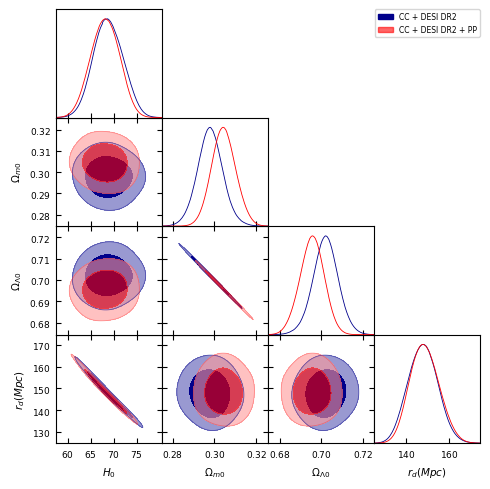

In [119]:
g = getdist.plots.getSubplotPlotter(width_inch=5.0)
g.settings.figure_legend_frame = True  # Remove frame around the legend
g.settings.alpha_filled_add = 0.6  # Adjust transparency of filled contours
g.settings.title_limit_fontsize = 9 # Limit title fontsize to 14
g.settings.axes_labelsize = 12  # Adjust label fontsize
g.settings.legend_fontsize = 10  # Adjust legend fontsize
g.settings.colorbar_axes_fontsize = 10  # Adjust colorbar fontsize
g.triangle_plot([posteriorCCBAO,posteriorCCBAOPP], ('H0','Om','Omega_Lambda','rd') ,filled=True, contour_colors=['darkblue','red'], legend_loc='upper right', legend_labels=[r'CC + DESI DR2', r'CC + DESI DR2 + PP'])
g.export("fig_1.pdf")

In [102]:
def get_constraints(samples):
    for i, mean in enumerate(samples.getMeans()):
        upper = samples.confidence(i, upper=True, limfrac=0.05)
        #print("\nupper limit 95 C.L. = %f" % upper)
        lower = samples.confidence(i, upper=False, limfrac=0.05)
        #print("lower limit 95 C.L. = %f" % lower)
        print("%s = %f +/- %f +/- %f" % (samples.parLabel(i),\

        mean, mean - samples.confidence(i, limfrac=0.16),\
        mean - samples.confidence(i, limfrac=0.025)) )
    return
for i in ["CCBAO",'CCBAOPP']:
    print(i)
    get_constraints(eval("posterior"+i))

CCBAO
H_{0} = 68.824823 +/- 3.045613 +/- 5.831795
\Omega_{m0} = 0.297923 +/- 0.005610 +/- 0.012037
r_d (Mpc) = 147.752732 +/- 7.292228 +/- 10.948242
L = 18.181064 +/- 1.072035 +/- 1.471345
L/Dof = 0.727243 +/- 0.042881 +/- 0.058854
p = 0.831022 +/- 0.040403 +/- 0.140064
\Omega_{\Lambda0} = 0.702077 +/- 0.005865 +/- 0.012074
CCBAOPP
H_{0} = 68.119705 +/- 3.044059 +/- 5.915476
\Omega_{m0} = 0.304424 +/- 0.005549 +/- 0.011287
r_d (Mpc) = 148.562456 +/- 6.910141 +/- 11.667802
L = 1420.627816 +/- 1.184921 +/- 1.541275
L/Dof = 0.879646 +/- 0.000734 +/- 0.000954
p = 0.999811 +/- 0.000015 +/- 0.000042
\Omega_{\Lambda0} = 0.695576 +/- 0.005420 +/- 0.011257


### Here We Compute The Log Of Bayesian Evidence


In [103]:
outputCCBAO

Global evidence:
log(Z)    -27.470458 +/-  0.310827

Local evidences:
log(Z_1)    -33.728105 +/-  0.463667
log(Z_2)    -29.980673 +/-  0.608533
log(Z_3)    -27.573726 +/-  0.321041

Run-time information:
ncluster           3
nposterior      1860
nequals           35
ndead           1860
nlive              0
nlike         126944
<nlike>        [0.0]

Parameter estimates:
H0            H_{0}                6.885E+01 +/- 2.997E+00
Om            \Omega_{m0}          2.989E-01 +/- 6.171E-03
rd            r_d (Mpc)            1.476E+02 +/- 6.519E+00
L             L                    1.806E+01 +/- 1.257E+00
Ldof          L/Dof                7.224E-01 +/- 5.030E-02
p             p                    8.358E-01 +/- 6.055E-02
Omega_Lambda  \Omega_{\Lambda0}    7.011E-01 +/- 6.171E-03

In [104]:
outputCCBAOPP

Global evidence:
log(Z)    -1430.113872 +/-  0.306854

Local evidences:
log(Z_1)     -1453.871245 +/-  0.866476
log(Z_2)     -1439.301013 +/-  0.648363
log(Z_3)     -1438.536180 +/-  0.430076
log(Z_4)     -1433.315938 +/-  0.411806
log(Z_5)     -1432.491376 +/-  0.315619
log(Z_6)     -1432.347597 +/-  0.318107
log(Z_7)     -1431.332116 +/-  0.310593
log(Z_8)     -1433.277548 +/-  0.335125
log(Z_9)     -1433.078646 +/-  0.331390
log(Z_10)    -1433.677124 +/-  0.346449
log(Z_11)    -1433.577664 +/-  0.321406
log(Z_12)    -1431.644503 +/-  0.313664
log(Z_13)    -1432.534794 +/-  0.316827

Run-time information:
ncluster          13
nposterior      1864
nequals          124
ndead           1864
nlive              0
nlike         202083
<nlike>        [0.0]

Parameter estimates:
H0            H_{0}                6.797E+01 +/- 3.198E+00
Om            \Omega_{m0}          3.052E-01 +/- 5.637E-03
rd            r_d (Mpc)            1.489E+02 +/- 7.024E+00
L             L                    1.42

$\Large \textbf{Dark Energy Survey Supernova}$

$\textbf{Source Link:}$ https://github.com/des-science/DES-SN5YR/blob/main/5_COSMOLOGY/SN_only_cosmosis_likelihood.py

$\textbf{Dataset Link:}$ https://github.com/des-science/DES-SN5YR/tree/main/4_DISTANCES_COVMAT

In this analysis, I use the full $\texttt{STAT+SYS}$ covariance matrix in this analysis.

In [105]:
#Load DES_SN_5Y dataset and Build the Covariance Matrix
values_filename = 'data/DES-SN5YR_HD.csv'
cov_filename = 'data/covsys_000.txt'

da = pd.read_csv(values_filename)
zcmb = da['zHD']
zhelio = da['zHEL']
mag = da['MU']
dmag = da['MUERR_FINAL'] 
N = len(mag)
syscov = np.loadtxt(cov_filename, skiprows=1).reshape((N, N))
cov = np.copy(syscov)
cov[np.diag_indices_from(cov)] += dmag**2
xdiag = 1/cov.diagonal()  # diagonal before marginalising constant
        # add marginalising over a constant
cov += 3**2
zmin = zcmb.min()
zmax = zcmb.max()
zmaxi = 1.1 ## we interpolate to 1.1 beyond that exact calc
print("DESY5: zmin=%f zmax=%f N=%i" % (zmin, zmax, N))
ninterp=150
zinter = np.linspace(1e-3, zmaxi, ninterp)
icov = la.inv(cov)

DESY5: zmin=0.025090 zmax=1.121320 N=1829


In [106]:
def chiInt_DES(theta, z):
    H0, Om, rd = theta
    z = np.array(z)
    z_sorted_unique = np.sort(np.unique(z))
    z_integrate = np.hstack((np.array([0]), z_sorted_unique))
    arr = odeint(dchidz, 0, z_integrate, args=(H0, Om, rd))
    chi_sorted = np.delete(arr, 0)
    chi_original_order = np.interp(z, z_sorted_unique, chi_sorted)
    return chi_original_order
chiInt_DES([67, 0.32, 147], [1, 2, 3])

array([0.7624812 , 1.18936468, 1.45585048])

In [107]:
def DL(theta,z):
    H0, Om, rd = theta
    chi = chiInt_DES(theta,z)
    return c*chi/H0

def mu(theta,z):
    H0, Om, rd = theta
    dL = DL(theta,z)
    mu = []

    for i in range(len(z)):
        mu.append(5*np.log10(dL[i]*(1+z[i])) + 25)
    mu = np.array(mu)
    mu.shape
    return mu

In [108]:
def A(theta, x, y, icov):
    Mu = mu(theta, x)
    residual = y - Mu 
    chit2 = residual.T @ icov @ residual
    B = np.sum(residual @ icov)
    C = np.sum(icov)
    chi2 = chit2 - (B**2 / C) + np.log(C / (2 * np.pi))
    return chi2

def lnlikeCCBAODESSN5YR(theta):
    chi = A(theta, zcmb, mag, icov)
    i = len(zcmb)
    OL = Omega_Lambda(theta)
    return -chi, [chi, chi/(i-len(theta)),1-stats.chi2.cdf(x=chi, df=(i-len(theta))),OL]

print(lnlikeCCBAODESSN5YR([67,0.32,147]))

(np.float64(-1639.5712226217324), [np.float64(1639.5712226217324), np.float64(0.8979031887304121), np.float64(0.9992775762674531), 0.6799999999999999])


In [109]:
def lnlikeCCBAODESSN5YR(theta):

    chi = lnlikecov(theta, funarr, np.array(BaoData[:, 0]), np.array(BaoData[:, 1]), cov_bao_inv)
    i = len(BaoData[:, 0])
    chi += lnlike(theta, H, z, Hz, cov_mat_cc); i += len(z)
    chi += A(theta, zcmb, mag, icov);i += len(zcmb)
    OL = Omega_Lambda(theta)
    return -chi, [chi, chi/(i-len(theta)), 1 - stats.chi2.cdf(x=chi, df=(i-len(theta))),OL]

print(lnlikeCCBAODESSN5YR([67,0.32,147]))

(np.float64(-1686.3098666805126), [np.float64(1686.3098666805126), np.float64(0.9095522474004922), np.float64(0.9976762520037377), 0.6799999999999999])


In [110]:
runs = 100

In [111]:
def dumper(live, dead, logweights, logZ, logZerr):
    print("Last dead point:", dead[-1])

In [112]:
def uniprior(hypercube):
    prior = []
    prior.append(UniformPrior(50.,100.)(hypercube[0]))
    prior.append(UniformPrior(0.,1.)(hypercube[1]))
    prior.append(UniformPrior(100.,200.)(hypercube[2]))
    return prior

In [113]:
settingsCCBAODESSN5YR = PolyChordSettings(3,4)
settingsCCBAODESSN5YR.file_root = 'CC + BAO + DES SN5YR'
settingsCCBAODESSN5YR.nlive = runs
settingsCCBAODESSN5YR.do_clustering = True
settingsCCBAODESSN5YR.read_resume = False

In [114]:
outputCCBAODESSN5YR = pypolychord.run_polychord(lnlikeCCBAODESSN5YR, 3,4, settingsCCBAODESSN5YR, uniprior, dumper)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.22.1
  release: 10th Jan 2024
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     100
nDims    :       3
nDerived :       4
Doing Clustering
Synchronous parallelisation
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file to chains/CC + BAO + DES SN5YR.resume

generating live points


all live points generated

Speed  1 =  0.768E-02 seconds
number of repeats:           15
started sampling

Last dead point: [ 7.50292589e+01  4.36012984e-02  1.85035078e+02  7.07419679e+03
  3.81564012e+00  0.00000000e+00  9.56398702e-01 -7.83683451e+03
 -7.07419679e+03]
________________
lives      |100 |
phantoms   |914 |
posteriors |101 |
equals     |  1 |
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
ncluster   =       1 /       1
ndead      =                 101
nposterio

In [115]:
paramnames = [('H0','H_{0}'),('Om', r'\Omega_{m0}'),('rd','r_d (Mpc)'),('L',r'L'),('Ldof',r'L/Dof'),('p','p'),('Omega_Lambda', r'\Omega_{\Lambda0}')]
outputCCBAODESSN5YR.make_paramnames_files(paramnames)

posteriorCCBAODESSN5YR = outputCCBAODESSN5YR.posterior

chains/CC + BAO + DES SN5YR.txt
Removed no burn in


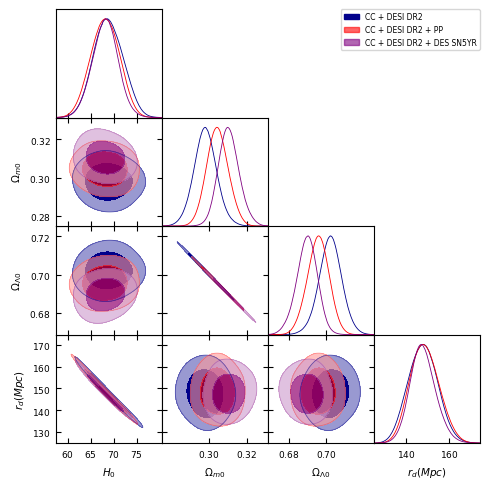

In [121]:
g = getdist.plots.getSubplotPlotter(width_inch=5.0)
g.settings.figure_legend_frame = True  # Remove frame around the legend
g.settings.alpha_filled_add = 0.6  # Adjust transparency of filled contours
g.settings.title_limit_fontsize = 9 # Limit title fontsize to 14
g.settings.axes_labelsize = 12  # Adjust label fontsize
g.settings.legend_fontsize = 10  # Adjust legend fontsize
g.settings.colorbar_axes_fontsize = 10  # Adjust colorbar fontsize
g.triangle_plot([posteriorCCBAO,posteriorCCBAOPP,posteriorCCBAODESSN5YR], ('H0','Om','Omega_Lambda','rd') ,filled=True, contour_colors=['darkblue','red','purple'], legend_loc='upper right', legend_labels=[r'CC + DESI DR2', r'CC + DESI DR2 + PP', r'CC + DESI DR2 + DES SN5YR'])
g.export("fig_2.pdf")

In [122]:
def get_constraints(samples):
    for i, mean in enumerate(samples.getMeans()):
        upper = samples.confidence(i, upper=True, limfrac=0.05)
        #print("\nupper limit 95 C.L. = %f" % upper)
        lower = samples.confidence(i, upper=False, limfrac=0.05)
        #print("lower limit 95 C.L. = %f" % lower)
        print("%s = %f +/- %f +/- %f" % (samples.parLabel(i),\

        mean, mean - samples.confidence(i, limfrac=0.16),\
        mean - samples.confidence(i, limfrac=0.025)) )
    return
for i in ['CCBAODESSN5YR']:
    print(i)
    get_constraints(eval("posterior"+i))

CCBAODESSN5YR
H_{0} = 68.131280 +/- 2.641959 +/- 5.193116
\Omega_{m0} = 0.310441 +/- 0.005315 +/- 0.009835
r_d (Mpc) = 147.795282 +/- 5.424047 +/- 10.283898
L = 1662.151663 +/- 1.066988 +/- 1.344593
L/Dof = 0.896522 +/- 0.000576 +/- 0.000725
p = 0.999432 +/- 0.000039 +/- 0.000122
\Omega_{\Lambda0} = 0.689559 +/- 0.005314 +/- 0.011768


In [123]:
outputCCBAODESSN5YR

Global evidence:
log(Z)    -1671.360623 +/-  0.302764

Local evidences:
log(Z_1)    -1673.362964 +/-  0.308770
log(Z_2)    -1673.940936 +/-  0.321105
log(Z_3)    -1673.479944 +/-  0.316785
log(Z_4)    -1673.686688 +/-  0.313009
log(Z_5)    -1674.398857 +/-  0.320572
log(Z_6)    -1672.601141 +/-  0.306055
log(Z_7)    -1672.821963 +/-  0.306845

Run-time information:
ncluster           7
nposterior      1848
nequals          140
ndead           1848
nlive              0
nlike         188303
<nlike>        [0.0]

Parameter estimates:
H0            H_{0}                6.809E+01 +/- 2.792E+00
Om            \Omega_{m0}          3.111E-01 +/- 6.017E-03
rd            r_d (Mpc)            1.478E+02 +/- 6.001E+00
L             L                    1.662E+03 +/- 1.600E+00
Ldof          L/Dof                8.966E-01 +/- 8.630E-04
p             p                    9.994E-01 +/- 6.425E-05
Omega_Lambda  \Omega_{\Lambda0}    6.889E-01 +/- 6.017E-03